In [1]:
import os
import re
import functions
import preprocessing_script as ps
import analyze_json
import pandas as pd
import numpy as np
import json
import random
import json
from IPython.display import display, JSON
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer as ST, util
from transformers import AutoTokenizer, BertTokenizer, pipeline, BertModel, BertForTokenClassification
from datasets import load_metric
import spacy
from spacy.tokens import DocBin
import spacy_transformers
from evaluate import load
from wordcloud import WordCloud

/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# 1. Load and clean datasets

In [3]:
users_df, isBot_t, isBot_f = ps.clean_users()
log_df = ps.clean_log()
profile_df = ps.clean_profile()
users_profile_df, users_not_in_profile_df = ps.clean_user_profile(users_df, profile_df)
users_profile_df = pd.read_csv("./outputs/translated_all_profile_answers.csv", sep="|")
profile_df.head()

,id,user_id,demography_body,age_min,age_max,gender,created_at,country,eyal_answers
0,1268,544860584,"{""labels"": {""QID2"": ""Male"", ""QID3"": ""Married"",...",45,54,male,2024-03-05 09:50:38.316897,ukraine,"{""labels"": ""{}"", ""values"": ""{}"", ""responseId"":..."
1,960,1047000229,"{""labels"": {""QID2"": ""Male"", ""QID3"": ""Complicat...",25,34,male,2024-02-28 09:31:13.869523,ukraine,"{""labels"": {""QID3"": ""2"", ""QID4"": ""5"", ""QID10"":..."
2,908,865654491,"{""labels"": {""QID1"": ""FB"", ""QID2"": ""Female"", ""Q...",25,34,female,2024-02-27 12:03:40.726419,ukraine,"{""labels"": {""QID3"": ""4-Somewhat Agree"", ""QID4""..."
3,1278,635305682,"{""labels"": {""QID1"": ""Friend"", ""QID2"": ""Male"", ...",35,44,male,2024-03-05 15:02:30.323420,ukraine,"{""labels"": ""{}"", ""values"": ""{}"", ""responseId"":..."
4,1162,5680929352,"{""labels"": {""QID1"": ""Click to write Choice 6"",...",35,44,female,2024-03-03 16:01:59.324326,ukraine,"{""labels"": {""QID3"": ""2"", ""QID4"": ""5"", ""QID10"":..."


# 2. All user count over time

/Users/Dong/Downloads/besample/functions.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_users_plot_df['created_at'] = all_users_plot_df['created_at'].dt.floor('d')
/Users/Dong/Downloads/besample/functions.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_users_plot_df['isBot_t'] = (all_users_plot_df['isBot'] == 1).astype(int)
/Users/Dong/Downloads/besample/functions.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

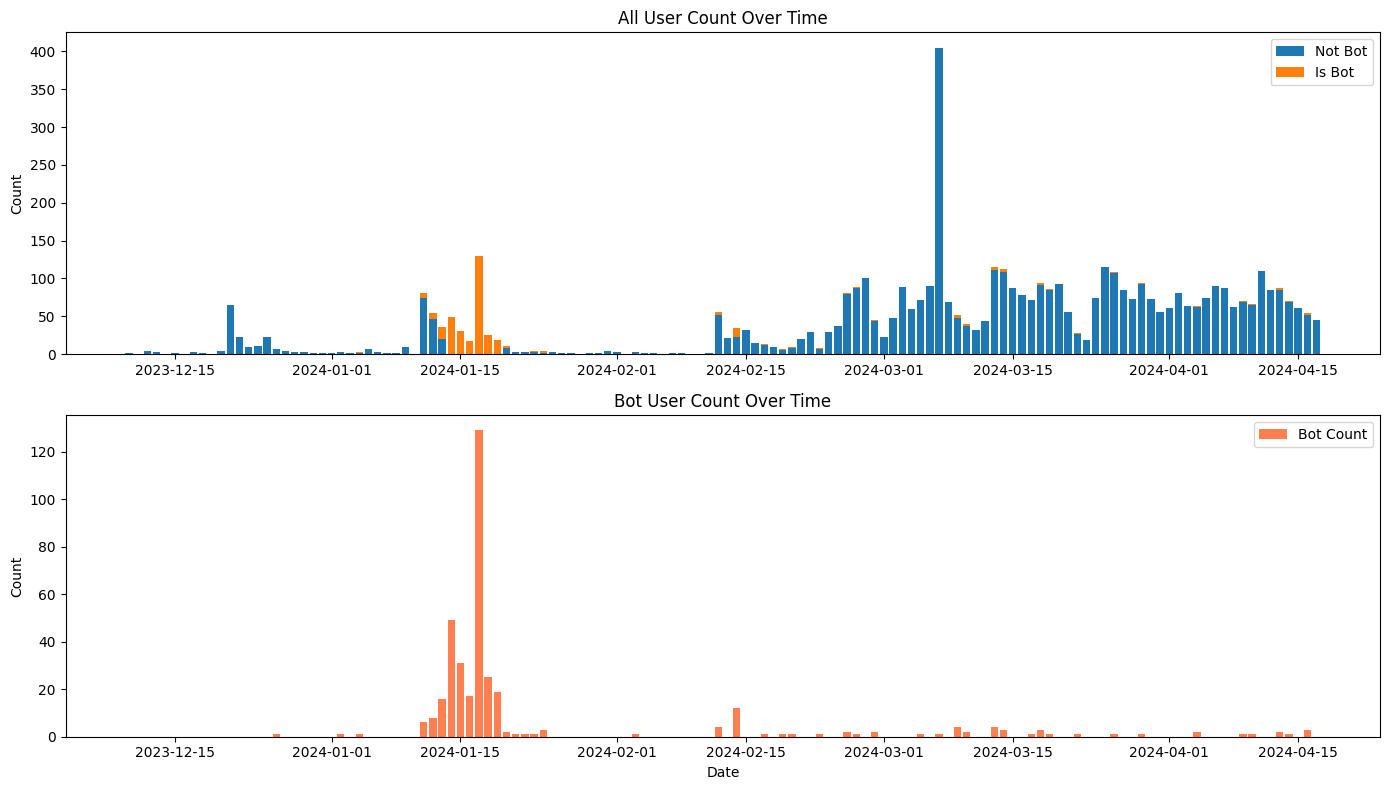

In [3]:
functions.users_over_time()

<div class="alert alert-success">

<b>Methodology</b>

The majority `isBot` user located around Jan 15th. But the registration of over 400 users on Mar. 7th seems abnormal, and there's no true values in `isBot` column. Therefore this task is more like a unsupervised learning project.

</div>


# 3. Extract and translate users' answers

## 3.1 Check languages

In [4]:
demo_df = profile_df.join(users_df[['isBot', 'ip']], how='left')
demo_df = demo_df[['user_id','created_at', 'ip', 'demography_body', 'isBot']]
demo_df['QID11_TEXT'] = demo_df['demography_body'].apply(analyze_json.extract_QID11_TEXT)
demo_df.QID11_TEXT.value_counts()

QID11_TEXT
-                                                                                                                                                                                      38
.                                                                                                                                                                                      31
Відповідальна                                                                                                                                                                          17
Відповідальний                                                                                                                                                                         12
Люблю свою роботу                                                                                                                                                                      11
                                                           

<div class="alert alert-success">
<b>Inspection</b>

The most repeated values are some meaningless marks

</div>

### 3.1.1 QID11 data quality

In [5]:
demo_df[demo_df['QID11_TEXT'].str.len() == 2]

,user_id,created_at,ip,demography_body,isBot,QID11_TEXT
19,38360,2023-12-17 11:37:34.183460,50.43.106.219,"{""labels"": {""QID1"": ""18-24"", ""QID2"": ""Nonbinar...",-1.0,Bb
27,179376382,2023-12-20 13:12:04.360213,45.89.90.241,"{""labels"": {""QID1"": ""Friend"", ""QID2"": ""Male"", ...",-1.0,—-
230,176048048,2024-01-12 12:57:01.331245,188.163.13.73,"{""labels"": {""QID1"": ""FB"", ""QID2"": ""Male"", ""QID...",-1.0,Лл
259,789445520,2024-01-14 10:16:18.729023,0.0.0.0,"{""labels"": {""QID1"": ""Google"", ""QID2"": ""Male"", ...",-1.0,——
267,670272439,2024-01-14 18:33:25.124905,46.211.236.240,"{""labels"": {""QID1"": ""Friend"", ""QID2"": ""Male"", ...",-1.0,Хм
337,1305235628,2024-01-17 11:06:19.899770,0.0.0.0,"{""labels"": {""QID1"": ""Friend"", ""QID2"": ""Male"", ...",-1.0,..
390,1080816238,2024-01-17 18:01:43.470302,178.215.164.30,"{""labels"": {""QID1"": ""Friend"", ""QID2"": ""Female""...",-1.0,Хз
472,6867019519,2024-01-18 20:41:20.937568,0.0.0.0,"{""labels"": {""QID1"": ""Blogger"", ""QID2"": ""Female...",-1.0,На
475,719301457,2024-01-19 10:10:58.902695,176.36.17.230,"{""labels"": {""QID1"": ""Friend"", ""QID2"": ""Female""...",-1.0,--
492,1669300480,2024-01-24 13:24:33.601053,0.0.0.0,"{""labels"": {""QID1"": ""FB"", ""QID2"": ""Male"", ""QID...",-1.0,ga


<div class="alert alert-success">
<b>Inspection</b>

Define input with length less than 3 as “meaningless input”

</div>

### 3.1.2 Check the languages

In [8]:
text_name = "./outputs/profile_QID11"

# Save all "QID11" from profile to "profile_QID11.txt", no need to run it again
# analyze_json.save_list_2_text(demo_df['QID11_TEXT'], text_name) # Already run, no need to run it again

languages_list = analyze_json.read_text_to_list(text_name)
analyze_json.language_detect(languages_list)

[2024-06-19 21:59:48,773][INFO] - Downloading https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin to lid.176.bin (125.2M)
100%|██████████| 125M/125M [00:14<00:00, 8.92MB/s] 


Russian = 440, Ukrainian = 4032, English = 461, other languages = 177.
For other languages:  [('it', 41), ('fr', 36), ('bg', 20), ('be', 13), ('mk', 13), ('de', 7), ('pt', 5), ('sr', 5), ('ja', 3), ('es', 3), ('sh', 2), ('az', 2), ('ky', 2), ('pl', 2), ('cs', 2), ('sv', 2), ('vi', 1), ('el', 1), ('kk', 1), ('xal', 1), ('tt', 1), ('he', 1), ('ceb', 1), ('nl', 1), ('ca', 1), ('oc', 1), ('zh', 1), ('hu', 1), ('mhr', 1), ('eu', 1), ('fi', 1), ('mn', 1), ('my', 1), ('jbo', 1), ('ms', 1)]


## 3.2 Translate all user answers to English

To create a new column that translate multiple languages into English

In [ ]:
# demo_df['translated'] = demo_df['QID11_TEXT'].apply(analyze_json.translate_2_en) # will take long time to run demo_df
# demo_df.to_csv(file_name, sep="|")

The process will take long time, almost 0.5s/row, especially for translating all open-ended answers, it took 7 hours. so I saved it to a csv file. 

The code of translating all user answers is in `analyze_json.py`

In [9]:
# users_profile_df = analyze_json.get_demography_text(users_profile_df)
# users_profile_df = analyze_json.get_eyal_answer_text(users_profile_df)
# Translate to English
# users_profile_df = analyze_json.translate(users_profile_df) # It takes 7 hours, no need to run it again
# users_profile_df.to_csv("./outputs/translated_all_profile_answers.csv", sep="|")

file_name = "./outputs/translated_all_profile_answers.csv"
translated_answers_df = pd.read_csv(file_name, sep="|")
translated_answers_df.head()

,Unnamed: 0,user_id,ip,created_at_user,created_at_profile,demography_body,eyal_answers,created_at_diff,date,QID11_TEXT,...,eyal_QID140_4_TEXT,QID11_TEXT_translated,QID18_TEXT_translated,QID22_TEXT_translated,QID31_TEXT_translated,eyal_QID81_TEXT_translated,eyal_QID84_TEXT_translated,eyal_QID110_TEXT_translated,eyal_QID154_TEXT_translated,eyal_QID140_4_TEXT_translated
0,0,453138625,0.0.0.0,2023-12-10 17:25:00.930627,2023-12-10 17:26:45.845550,"{""labels"": {""QID1"": ""35-44"", ""QID2"": ""Female"",...","{""labels"": ""{}"", ""values"": ""{}"", ""responseId"":...",0 days 00:01:44.914923,2023-12-10,No QID11_TEXT,...,No answer,No QID11_TEXT,No QID18_TEXT,No QID22_TEXT,No QID31_TEXT,No answer,No answer,No answer,Empty Input,No answer
1,1,6341233829,0.0.0.0,2023-12-12 14:14:54.118966,2023-12-12 14:17:51.079421,"{""labels"": {""QID1"": ""18-24"", ""QID2"": ""Female"",...","{""labels"": ""{}"", ""values"": ""{}"", ""responseId"":...",0 days 00:02:56.960455,2023-12-12,No QID11_TEXT,...,No answer,No QID11_TEXT,No QID18_TEXT,No QID22_TEXT,No QID31_TEXT,No answer,No answer,No answer,Empty Input,No answer
2,2,1923465442,0.0.0.0,2023-12-12 22:07:51.516993,2023-12-12 22:28:14.178576,"{""labels"": {""QID1"": ""Click to write Choice 5"",...","{""labels"": ""{}"", ""values"": ""{}"", ""responseId"":...",0 days 00:20:22.661583,2023-12-12,Я чрезвычайно увлеченный и целеустремленный че...,...,No answer,I am an extremely passionate and driven person...,Georgian,Europeanoid,"- Development, optimization and support of com...",No answer,No answer,No answer,Empty Input,No answer
3,3,38360,0.0.0.0,2023-12-17 11:35:03.620461,2023-12-17 11:37:34.183460,"{""labels"": {""QID1"": ""18-24"", ""QID2"": ""Nonbinar...","{""labels"": ""{}"", ""values"": ""{}"", ""responseId"":...",0 days 00:02:30.562999,2023-12-17,Bb,...,No answer,Bb,Ukrainian,B,Hv,No answer,No answer,No answer,Empty Input,No answer
4,4,202223263,31.144.160.37,2023-12-18 23:36:54.536116,2023-12-18 23:46:12.765152,"{""labels"": {""QID1"": ""Click to write Choice 5"",...","{""labels"": ""{}"", ""values"": ""{}"", ""responseId"":...",0 days 00:09:18.229036,2023-12-18,Дякую\n,...,No answer,thank you,Russian,the jews,I work with children,No answer,No answer,No answer,Empty Input,No answer


# 4. Clusters of referral ancestors

## 4.1 Extract and draw relationship of ancestors plot

<div class="alert alert-success">
<b>Inspection</b>

I'll visulaize the relationship between `uuid` and `came_from`.

I used the example of [Module Dependencies](https://graphviz.org/Gallery/neato/softmaint.html) in `Graphviz` library

Because graphviz couldn't accept combination of letter and number, so I use `user_id` to replace `uuid`. It also looks more clearly.

Steps:

* Step 1: Generate ancestor pair of `came_from` and `uuid`
* Step 2: Copy all ancestor pairs to "ancestor_relationship.gv.txt" manually
* Step 3: Generate the ancestor relationship figure

</div>

In [5]:
# Step 1: Generate ancestor pair of `came_from` and `uuid`
came_from_df = functions.generate_ancestor_pair(users_df)

outputs/came_from_userid.txt has been created.


In [6]:
# Step 2: Copy all ancestor pairs to "ancestor_relationship.gv.txt" manually
# Step 3: Generate the ancestor relationship figure
functions.generate_relaionship_figure()

![img](./outputs/graph.png)

<div class="alert alert-success">
<b>Inspection</b>

There are about 10 clusters contain many users. I need to check their answers.

</div>

# 4.2 Check ancestor's answer

In [7]:
clusters = functions.get_clusters(users_df)
for cluster in clusters.keys():
    print(f"The number of users in {cluster} = {len(clusters[cluster])}")

The number of users in cluster1 = 101
The number of users in cluster2 = 69
The number of users in cluster3 = 39
The number of users in cluster4 = 23
The number of users in cluster5 = 12
The number of users in cluster6 = 13
The number of users in cluster7 = 9
The number of users in cluster8 = 9
The number of users in cluster9 = 11
The number of users in cluster10 = 23
The number of users in cluster11 = 101


In [8]:
cluster_df = pd.DataFrame()
for k, v in clusters.items():
    temp_df = pd.DataFrame({'user_id': v})
    temp_df['cluster'] = k
    cluster_df = pd.concat([cluster_df, temp_df])
cluster_df

,user_id,cluster
0,629425715,cluster1
1,630991301,cluster1
2,635691326,cluster1
3,1434085294,cluster1
4,186364599,cluster1
...,...,...
96,6773834907,cluster11
97,879318569,cluster11
98,831745576,cluster11
99,5614654774,cluster11


In [ ]:
cluster_QID11_answer_df = pd.merge(cluster_df, users_profile_df[['user_id', 'ip', 'date', "QID11_TEXT_translated"]], how='left')
# cluster_QID11_answer_df.to_csv("./outputs/cluster_QID11_answer.csv", sep="|")

According to the ancestor-user relationship graph, I made analysis one cluster by one.

<b>Conclusion</b>

Most of users in cluster 10 and 11 can be identified as Bots. They have lots of same IP addresses, they registered within a short time period, they have highly similar QID11 answers.

Most of users in cluster 1 and 2 are suspected to be Bots. They have some same IP addresses, some of them registered within a short time period, and they have similar QID11 answer patterns.

Some of users from other clusters have similar features as above. 

Please check my [detailed analysis document](https://docs.google.com/document/d/1Ig9Aa2XJrIkwYfmz_eFaKys4saEDCY3x1oq_xsEt8RA/edit?usp=sharing).

# 5. Combine important columns with user answers


I generated an excel file contains `user_id`, `cluster`, `IP`, `created_at`, `QID11_translated` and `QID154_translated`. 



In [ ]:
cluster_QID11_answer_df = pd.read_csv("./outputs/cluster_QID11_answer.csv", sep="|")
all_users_with_answers = pd.merge(users_df[['user_id', 'created_at', 'ip']], users_profile_df[['user_id', 'QID11_TEXT_translated']], how='left')
mask = all_users_with_answers['user_id'].isin(cluster_QID11_answer_df['user_id'])
complement_cluster_QID11_answer_df = all_users_with_answers[~mask]
complement_cluster_QID11_answer_df.to_csv("./outputs/complement_cluster_QID11_answers_df.csv")

From now on, my majority work is based on this excel file rather than the Jupyter notebook.

**My works on excel file:**

1. Inspected and analyzed user answers with the combination of clusters, peak registration time, IP address, etc.

2. Classified different patterns according to user answers

3. Created the scoring mechanism.

# 6. Essential analysis of user answers

## 6.1 Word Frequency

In [2]:
df = pd.read_excel("./outputs/Qid11_Qid154_answers.xlsx")
df.head()

,user_id,cluster,ip,IP feature,created_at,QID11_TEXT_translated,QID11_TEXT,QID11_answer_fature,eyal_QID154_TEXT_translated,eyal_QID154_TEXT,QID154_answer_feature,same IP and similar answer,Peak Period,Other features,cluster score,IP score,create_at_score,QID11_score,White list,total_score
0,665635129,NaN,188.163.43.23,not repeatly IP,2024-03-16 15:05:52.043,I work I live I cook delicious food.\nI am wai...,Працюю. Живу. Готую смачну їжу.\nЧекаю Перемоги !,NaN,1,1,NaN,NaN,NaN,NaN,0.0,0.00,0.5,0.2,1,0.165
1,908619832,NaN,0.0.0.0,Unknown IP,2024-02-26 14:32:39.581,"Attention, perseverance, information search, r...","Внимание, усидчивость, поиск информации, чтение","""Ajd, …"" pattern",2 years without work. She was an office manage...,2 Ð³Ð¾Ð´Ð° Ð±ÐµÐ· Ñ€Ð°Ð±Ð¾Ñ‚Ñ‹. Ð‘Ñ‹Ð»Ð° Ð¾Ñ„Ð...,NaN,NaN,NaN,NaN,0.0,0.25,0.5,0.7,1,0.440
2,595660822,NaN,5.58.154.34,not repeatly IP,2024-03-07 16:41:52.855,Music sport,Музика спорт,NaN,2. Sports,2. Sports,NaN,NaN,NaN,NaN,0.0,0.00,0.5,0.2,1,0.165
3,307938095,NaN,188.163.35.1,not repeatly IP,2024-03-24 20:28:36.384,Ordinary person,Звичайна людина,"""Ordinary "" pattern",24/7 at home,24/7 Ð²Ð´Ð¾Ð¼Ð°,NaN,NaN,NaN,NaN,0.0,0.00,0.5,0.7,1,0.390
4,680866658,NaN,93.127.100.207,not repeatly IP,2024-04-05 19:25:52.696,Studied as a painter. I independently learned ...,Вчилась на живописця. Самостійно вивчила софт ...,NaN,3d artist,3d artist,NaN,NaN,NaN,NaN,0.0,0.00,0.5,0.2,1,0.165


In [4]:
nltk.download('stopwords')
punctuation_symbols = set([string.punctuation[i] for i in range(len(string.punctuation))])
stop_words = set(stopwords.words('english'))
stop_words.update(punctuation_symbols)
stop_words.update({"[CLS]", "[SEP]"})

[nltk_data] Downloading package stopwords to /Users/Dong/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def get_word_freq(corpus):
    encoded_input = tokenizer(corpus, 
                              truncation = True,
                              padding = False,
                              add_special_tokens = True,
                              max_length = 128,
                              # return datatype: tf, pt, np, the default None is list
                              return_tensors = None,
                              return_token_type_ids = True,
                              return_attention_mask=True,
                              return_special_tokens_mask=True,
                              return_length = True)
    word_counts = {}
    for input_ids in encoded_input["input_ids"]:
      for token_id in input_ids:
        word = tokenizer.decode(token_id)
        if word not in stop_words:
          if word in word_counts:
            word_counts[word] += 1
          else:
            word_counts[word] = 1
    word_freq = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    sorted_word_freq = word_freq.sort_values(by='frequency', ascending=False)
    return sorted_word_freq

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like bert-base-uncased is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

### 6.1.1 QID154 word frequency

In [ ]:
corpus = df['eyal_QID154_TEXT_translated'].dropna().to_list()
sorted_word_freq = get_word_freq(corpus)
sorted_word_freq[:10]

### 6.1.2 QID11 word frequency

In [ ]:
corpus = df['QID11_TEXT_translated'].dropna().to_list()
sorted_word_freq = get_word_freq(corpus)
sorted_word_freq[:10]

## 6.2 Word Cloud

### 6.2.1 QID154 word cloud

In [ ]:
# Remove some most frequently but with little meaning words
popular_words = ['input', 'empty', 'like', 'love', "time", 'free', 'person', 'work']
sorted_word_freq = sorted_word_freq[~sorted_word_freq['word'].isin(popular_words)]
wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate_from_frequencies(dict(zip(sorted_word_freq['word'], sorted_word_freq['frequency'])))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 6.2.2 QID11 word cloud

In [ ]:
popular_words = ['input', 'empty', 'like', 'love', "time", 'free', 'person', 'work']
sorted_word_freq = sorted_word_freq[~sorted_word_freq['word'].isin(popular_words)]
wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate_from_frequencies(dict(zip(sorted_word_freq['word'], sorted_word_freq['frequency'])))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 6.3 Analyze QID11 and QID154

In [13]:
qid11_qid154_df = pd.read_csv("./outputs/translated_all_profile_answers.csv", sep='|')
qid11_qid154_df = qid11_qid154_df[['user_id',"ip","date",'QID11_TEXT_translated', 'eyal_QID154_TEXT_translated']]
qid11_qid154_df.head()

,user_id,ip,date,QID11_TEXT_translated,eyal_QID154_TEXT_translated
0,453138625,0.0.0.0,2023-12-10,No QID11_TEXT,Empty Input
1,6341233829,0.0.0.0,2023-12-12,No QID11_TEXT,Empty Input
2,1923465442,0.0.0.0,2023-12-12,I am an extremely passionate and driven person...,Empty Input
3,38360,0.0.0.0,2023-12-17,Bb,Empty Input
4,202223263,31.144.160.37,2023-12-18,thank you,Empty Input


### 6.3.1 Finding the empty input in both answers

In [14]:
qid11_qid154_df['QID11_TEXT_translated'] = qid11_qid154_df['QID11_TEXT_translated'].fillna("Empty Input")
qid11_qid154_df['QID11_TEXT_translated'] = qid11_qid154_df['QID11_TEXT_translated'].replace('No QID11_TEXT', "Empty Input")
qid11_qid154_df['eyal_QID154_TEXT_translated'] = qid11_qid154_df['eyal_QID154_TEXT_translated'].replace('No QID154_TEXT', "Empty Input")

In [15]:
qid11_qid154_df[qid11_qid154_df['eyal_QID154_TEXT_translated'] == "Empty Input"]

,user_id,ip,date,QID11_TEXT_translated,eyal_QID154_TEXT_translated
0,453138625,0.0.0.0,2023-12-10,Empty Input,Empty Input
1,6341233829,0.0.0.0,2023-12-12,Empty Input,Empty Input
2,1923465442,0.0.0.0,2023-12-12,I am an extremely passionate and driven person...,Empty Input
3,38360,0.0.0.0,2023-12-17,Bb,Empty Input
4,202223263,31.144.160.37,2023-12-18,thank you,Empty Input
...,...,...,...,...,...
4179,469475910,109.86.128.28,2024-04-17,"Since I’m on maternity leave, I’m trying to ea...",Empty Input
4180,697051190,77.121.11.10,2024-04-17,Meaningless input,Empty Input
4181,378497155,84.234.108.144,2024-04-17,"Mom, a future freelance designer. I love every...",Empty Input
4182,484166157,212.15.142.135,2024-04-17,"I love to read fiction, cook, draw and sing.\n...",Empty Input


In [16]:
qid11_qid154_df[qid11_qid154_df['eyal_QID154_TEXT_translated'] == "Meaningless input"]

,user_id,ip,date,QID11_TEXT_translated,eyal_QID154_TEXT_translated
278,688063138,5.199.233.128,2024-01-16,Everything is in the survey,Meaningless input
539,361077881,80.92.238.85,2024-02-15,"There is little time for this, sorry",Meaningless input
1685,486022990,91.202.1.224,2024-03-13,"I am a creative person, I like to learn and sh...",Meaningless input
1701,926178773,46.229.61.78,2024-03-13,Meaningless input,Meaningless input
1889,288371489,178.133.232.216,2024-03-15,Meaningless input,Meaningless input
2010,764406857,91.201.240.6,2024-03-16,Meaningless input,Meaningless input
2040,877121123,141.138.119.198,2024-03-17,Meaningless input,Meaningless input
2048,753431305,94.244.38.111,2024-03-17,Children\nQuickly\nActively,Meaningless input
2302,877579547,188.163.116.169,2024-03-20,"My favorite activity is design, regardless of ...",Meaningless input
2447,1578685234,185.137.218.139,2024-03-24,Meaningless input,Meaningless input


### 6.3.2 Calculate similarity between these two answers

In [17]:
temp_df = qid11_qid154_df[qid11_qid154_df['eyal_QID154_TEXT_translated'] != "Empty Input"]
temp_df.shape

(1954, 5)

In [18]:
matched_rows = temp_df[temp_df['QID11_TEXT_translated'] == temp_df['eyal_QID154_TEXT_translated']]
matched_rows[matched_rows['QID11_TEXT_translated'] != 'Meaningless input']

,user_id,ip,date,QID11_TEXT_translated,eyal_QID154_TEXT_translated
591,5176317363,209.198.131.80,2024-02-22,Ordinary person,Ordinary person
904,395895996,194.107.179.130,2024-03-02,"My name is Victoria, I am a 3D visualizer. I'm...","My name is Victoria, I am a 3D visualizer. I'm..."
965,697774655,146.120.227.212,2024-03-03,Socially active housewife,Socially active housewife
1025,544146975,91.243.16.10,2024-03-04,Great,Great
1169,853434709,46.211.228.235,2024-03-07,Do beads,Do beads
2102,5768173355,88.155.134.118,2024-03-18,Ukrainian woman,Ukrainian woman
2144,571501705,37.73.1.4,2024-03-18,Medicine,Medicine
2209,1358422907,91.229.123.73,2024-03-19,Workaholic,Workaholic
2690,1972905261,176.36.205.171,2024-03-27,"Responsible, communicative, I always work for ...","Responsible, communicative, I always work for ..."
2803,2054636830,31.144.173.106,2024-03-28,hardworking,hardworking


In [19]:
model = ST("all-MiniLM-L6-v2")
model.max_seq_length = 60 # default is 256 token which corresponds about 150-200 words

No sentence-transformers model found with name sentence-transformers/all-MiniLM-L6-v2. Creating a new one with mean pooling.
/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like sentence-transformers/all-MiniLM-L6-v2 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:
def cal_sim(row):
    qid11 = row["QID11_TEXT_translated"]
    qid154 = row["eyal_QID154_TEXT_translated"]
    qid11_embedding = model.encode(qid11, convert_to_tensor=True)
    qid154_embedding = model.encode(qid154, convert_to_tensor=True)

    # Compute cosine-similarities
    cosine_scores = util.cos_sim(qid11_embedding, qid154_embedding)
    return cosine_scores.detach().numpy()[0][0]

temp_df['cos_sim'] = temp_df.apply(cal_sim, axis=1)
temp_df.head()

In [ ]:
temp_df.sort_values('cos_sim', ascending=False).head(30)

## 6.4 Calculate similarities between pattern examples with user answers

In [20]:
# calculate the similarity
df = pd.read_excel("./outputs/520.xlsx", sheet_name="final")
df.head()

,user_id,cluster,ip,ip_isp,ip_org,ip_is_proxy,IP feature,created_at,QID11_TEXT_translated,QID11_answer_fature,...,Peak Period,Other features,cluster score,IP score,create_at_score,QID11_score,White list,total_score,isBot,QID11_TEXT
0,509954251,NaN,92.253.215.144,Roman Kalita,Kalita Roman Bogdanovych,0.0,same IP,2024-02-29 16:42:25.644,"Attentive, responsible","""Attentive, …"" pattern",...,NaN,NaN,0.0,0.5,0.5,0.7,1,0.490,0,"Уважний, відповідальний"
1,646387110,NaN,45.89.90.245,Servisnet Ltd.,Servisnet Ltd,0.0,same IP,2024-03-07 15:19:38.977,I am a mother on maternity leave with an unmar...,"""on maternity leave"" pattern",...,peak period and similar answer pattern,NaN,0.0,0.5,1.0,0.7,1,0.565,0,"Я мама у декреті з чоловіком не одружена, живу..."
2,6254278245,NaN,91.225.224.105,HomeNet,Homenet LLC,0.0,same IP,2024-03-18 18:05:08.814,"I am hardworking, talented, focused on work","""Hardworking, …"" pattern",...,NaN,NaN,0.0,0.5,0.8,0.7,1,0.535,0,"Я працьовита, талановита, зосереджена на роботі"
3,166513932,cluster5,46.63.98.49,X-city Customers and Private,NaN,0.0,not repeatly IP,2024-03-07 15:19:36.132,"I am a strong, responsible, detail-oriented, c...",I am a… pattern,...,NaN,NaN,0.5,0.0,0.8,NaN,1,0.220,0,"Я сильна, відповідальна, уважна до деталей, тв..."
4,275217887,NaN,91.236.250.15,IP-Connect LLC,TC-node,0.0,not repeatly IP,2024-04-09 11:37:42.186,"I am a creative person, I like to listen to ma...","""I am a creative person…"" pattern",...,NaN,NaN,0.0,0.0,0.5,0.7,1,0.390,0,"Я творча людина, люблю прослуховувати безліч ..."


In [ ]:
model = ST("all-MiniLM-L6-v2")
model.max_seq_length = 120 # default is 256 token which corresponds about 150-200 words

In [ ]:
def open_patterns(text_name):
    pattern_list = []
    with open(f"./outputs/{text_name}.txt", "r") as file:
        for answer in file:
            pattern_list.append(answer)
    return pattern_list
patterns_1 = open_patterns("patterns_1")
patterns_2 = open_patterns("patterns_2")
pattern1_embedding = model.encode(patterns_1, convert_to_tensor=True)
pattern2_embedding = model.encode(patterns_2, convert_to_tensor=True)

In [ ]:
def cal_sim_1(row):
    answer = str(row['QID11_TEXT_translated'])
    if answer != "":
        answer_embedding = model.encode(answer, convert_to_tensor=True)
        # Compute cosine-similarities
        cosine_scores_1 = util.cos_sim(pattern1_embedding, answer_embedding)
        max_score_1 = max(cosine_scores_1.view(-1).tolist())
    return max_score_1

def cal_sim_2(row):
    answer = str(row['QID11_TEXT_translated'])
    if answer != "":
        answer_embedding = model.encode(answer, convert_to_tensor=True)
        # Compute cosine-similarities
        cosine_scores_2 = util.cos_sim(pattern2_embedding, answer_embedding)
        max_score_2 = max(cosine_scores_2.view(-1).tolist())
    return max_score_2

In [ ]:
df['sim_score_1'] = df.apply(cal_sim_1, axis=1)
df['sim_score_2'] = df.apply(cal_sim_2, axis=1)

In [ ]:
df[['user_id', "sim_score_1", "sim_score_2"]].to_excel("./outputs/sim_score_v1.xlsx")

In [ ]:
df[(df['sim_score_1'] > 0.194180) | (df['sim_score_1'] < 0.194179)]['sim_score_1'].plot(kind='hist', bins=25)
plt.title("Distribution of similarity scores")
plt.show()

# 7. Compare the total score to `isBot`

In [21]:
final_df = pd.read_excel("./outputs/final_result.xlsx", sheet_name="without_cluster_IP")
final_df.head()

,user_id,cluster,ip,ip_isp,ip_org,ip_is_proxy,IP feature,created_at,QID11_TEXT_translated,QID11_answer_fature,...,cluster score,IP score,create_at_score,QID11_score,pattern_score_1,pattern_score_2,White list,total_score,isBot,QID11_TEXT
0,509954251,NaN,92.253.215.144,Roman Kalita,Kalita Roman Bogdanovych,0.0,same IP,2024-02-29 16:42:25.644,"Attentive, responsible","""Attentive, …"" pattern",...,0.0,0.5,0.5,0.7,1.0,0.679634,1,0.675,0,"Уважний, відповідальний"
1,646387110,NaN,45.89.90.245,Servisnet Ltd.,Servisnet Ltd,0.0,same IP,2024-03-07 15:19:38.977,I am a mother on maternity leave with an unmar...,"""on maternity leave"" pattern",...,0.0,0.5,1.0,0.7,1.0,0.313967,1,0.825,0,"Я мама у декреті з чоловіком не одружена, живу..."
2,6254278245,NaN,91.225.224.105,HomeNet,Homenet LLC,0.0,same IP,2024-03-18 18:05:08.814,"I am hardworking, talented, focused on work","""Hardworking, …"" pattern",...,0.0,0.5,0.8,0.7,1.0,0.666374,1,0.765,0,"Я працьовита, талановита, зосереджена на роботі"
3,166513932,cluster5,46.63.98.49,X-city Customers and Private,NaN,0.0,not repeatly IP,2024-03-07 15:19:36.132,"I am a strong, responsible, detail-oriented, c...",I am a… pattern,...,0.5,0.0,0.8,NaN,1.0,0.687300,1,0.220,0,"Я сильна, відповідальна, уважна до деталей, тв..."
4,275217887,NaN,91.236.250.15,IP-Connect LLC,TC-node,0.0,not repeatly IP,2024-04-09 11:37:42.186,"I am a creative person, I like to listen to ma...","""I am a creative person…"" pattern",...,0.0,0.0,0.5,0.7,1.0,0.543644,1,0.745,0,"Я творча людина, люблю прослуховувати безліч ..."


In [22]:
final_df['isBot'].value_counts()

isBot
0    4700
1     370
Name: count, dtype: int64

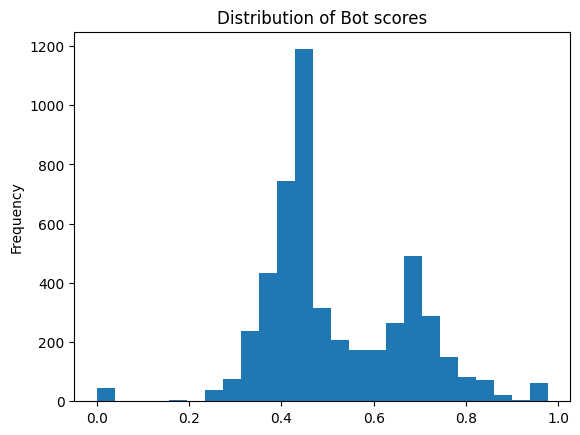

In [23]:
final_df['total_score'].plot(kind='hist', bins=25)
plt.title("Distribution of Bot scores")
plt.show()

In [24]:
match_1 = final_df[final_df['total_score'] > 0.7]
match_1.shape

(755, 25)

In [25]:
match_1['isBot'].value_counts()

isBot
0    607
1    148
Name: count, dtype: int64

In [26]:
148/370

0.4